<a href="https://colab.research.google.com/github/GiacomoT23/Euro-MachineTranslation-SFT-and-RL/blob/main/de_en_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing correct numpy version

In [ ]:
!pip -q install "numpy<2.0.0" #needed for fasttext (language detection)
!pip -q install fasttext==0.9.2 huggingface_hub
import os

print("✅ Installation completed. Restarting runtime")
os.kill(os.getpid(), 9)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 54.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np, fasttext
print("NumPy:", np.__version__) #check

NumPy: 1.26.4


# Dataset download

Downloading de-en dataset from WMT14.

In [ ]:
!pip -q install "datasets>=3.4.1,<4.0.0"
from datasets import load_dataset

YEAR = "wmt14"
PAIR = "de-en"
SRC, TGT = PAIR.split("-")

ds = load_dataset(YEAR, PAIR)

print({split: len(ds[split]) for split in ds.keys()})
ds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 15.2 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

de-en/train-00000-of-00003.parquet:   0%|          | 0.00/280M [00:00<?, ?B/s]

de-en/train-00001-of-00003.parquet:   0%|          | 0.00/265M [00:00<?, ?B/s]

de-en/train-00002-of-00003.parquet:   0%|          | 0.00/273M [00:00<?, ?B/s]

de-en/validation-00000-of-00001.parquet:   0%|          | 0.00/474k [00:00<?, ?B/s]

de-en/test-00000-of-00001.parquet:   0%|          | 0.00/509k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4508785 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3003 [00:00<?, ? examples/s]

{'train': 4508785, 'validation': 3000, 'test': 3003}


DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 4508785
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 3003
    })
})

# Model

Using Qwen2.5 1.5B base

In [ ]:
%%capture
!pip install --no-input unsloth bitsandbytes accelerate peft "trl>=0.9.0" sentencepiece protobuf hf_transfer
!pip install --no-input "transformers==4.55.4"
from unsloth import FastLanguageModel
import torch, os

USE_4BIT = True
USE_GC   = "unsloth"
MAX_SEQ  = 256
MODEL_ID = "unsloth/Qwen2.5-1.5B"

dtype = None if USE_4BIT else torch.float16
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name     = MODEL_ID,
    max_seq_length = MAX_SEQ,
    dtype          = dtype,
    load_in_4bit   = USE_4BIT,
)

# Adding LoRa adapters
model = FastLanguageModel.get_peft_model(
    model,
    r = 8,
    target_modules = ["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = USE_GC,
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model: {MODEL_ID} | 4bit={USE_4BIT} | GC={USE_GC} | seq={MAX_SEQ}")
print(f"Trainable params (LoRA+heads): ~{n_params:,}")

# Dataset exploration: lengths (in tokens) distributions

Exploring sample length distribution (in tokens) in training set (a sample), validation set and test set

✔️ Train sample: 65,536 righe (da 4,508,785)


[train-sampled] token lengths (num_proc=2):   0%|          | 0/65536 [00:00<?, ? examples/s]

[train-sampled] Percentili (token, no specials)
  SRC     : {'p50': 36, 'p90': 74, 'p95': 89, 'p99': 125}
  TGT     : {'p50': 25, 'p90': 50, 'p95': 61, 'p99': 87}
  SRC+TGT : {'p50': 62, 'p90': 121, 'p95': 145, 'p99': 203}


[validation] token lengths (num_proc=2):   0%|          | 0/3000 [00:00<?, ? examples/s]

[validation] Percentili (token, no specials)
  SRC     : {'p50': 30, 'p90': 62, 'p95': 75, 'p99': 101}
  TGT     : {'p50': 21, 'p90': 42, 'p95': 50, 'p99': 69}
  SRC+TGT : {'p50': 51, 'p90': 104, 'p95': 125, 'p99': 169}


[test] token lengths (num_proc=2):   0%|          | 0/3003 [00:00<?, ? examples/s]

[test] Percentili (token, no specials)
  SRC     : {'p50': 33, 'p90': 63, 'p95': 73, 'p99': 91}
  TGT     : {'p50': 23, 'p90': 43, 'p95': 49, 'p99': 63}
  SRC+TGT : {'p50': 56, 'p90': 105, 'p95': 120, 'p99': 151}


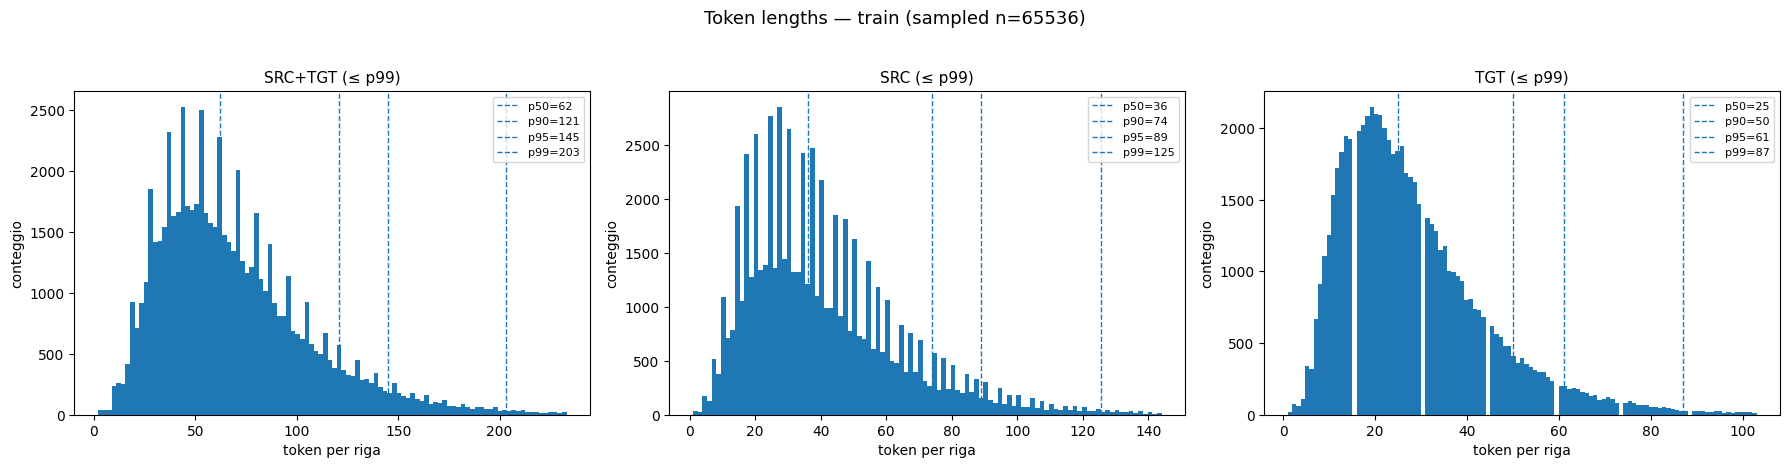

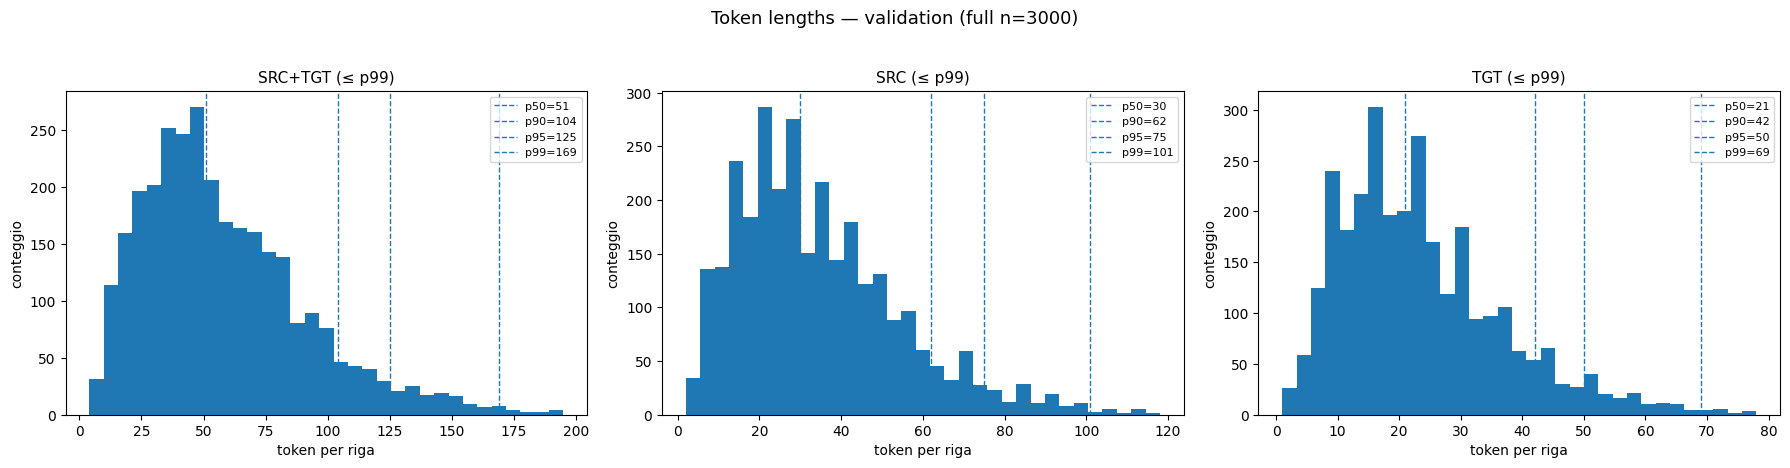

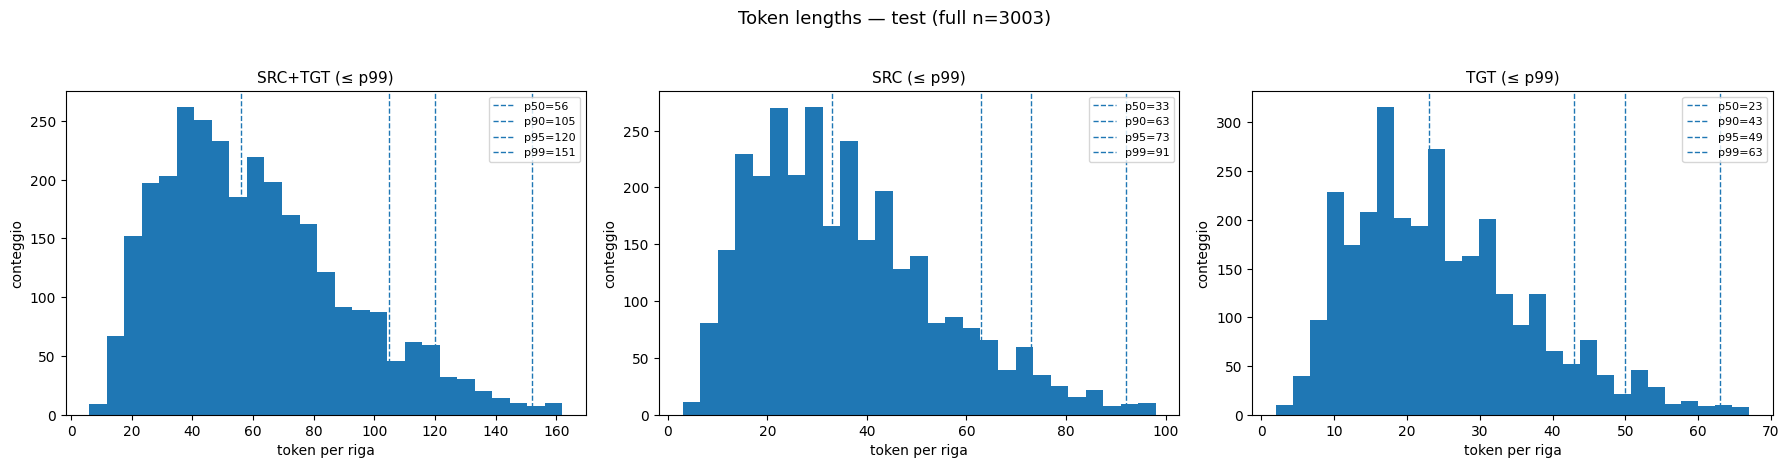

In [ ]:
# Sampling train + length stats (train-sampled, val full, test full) ===
import os, numpy as np
import matplotlib.pyplot as plt

TRAIN_SAMPLE_N = 65_536
SEED = 3407

def percentili(a):
    a = np.asarray(a)
    return {k:int(v) for k,v in zip(["p50","p90","p95","p99"], np.percentile(a, [50,90,95,99]))}

# sampling of training set
N_train = len(ds["train"])
rng = np.random.default_rng(SEED)
idx_train_sample = rng.choice(N_train, size=min(TRAIN_SAMPLE_N, N_train), replace=False)
train_sample = ds["train"].select(idx_train_sample.tolist())
print(f"✔️ Train sample: {len(train_sample):,} rows (from {N_train:,})")

# function to add lengths
def add_lengths(batch):
    src = [x[SRC] for x in batch["translation"]]
    tgt = [x[TGT] for x in batch["translation"]]
    enc_s = tokenizer(src, add_special_tokens=False, return_length=True,
                      return_attention_mask=False, return_token_type_ids=False)
    enc_t = tokenizer(tgt, add_special_tokens=False, return_length=True,
                      return_attention_mask=False, return_token_type_ids=False)
    len_src = enc_s["length"]; len_tgt = enc_t["length"]
    return {"len_src": len_src, "len_tgt": len_tgt, "len_sum": (np.array(len_src)+np.array(len_tgt)).tolist()}

def lengths_for_split(dset, split_name, num_proc=2, batch_size=4096):
    d2 = dset.map(add_lengths, batched=True, batch_size=batch_size, num_proc=num_proc,
                  desc=f"[{split_name}] token lengths")
    ls = np.array(d2["len_src"], dtype=np.int32)
    lt = np.array(d2["len_tgt"], dtype=np.int32)
    lm = np.array(d2["len_sum"], dtype=np.int32)
    print(f"[{split_name}] Percentiles")
    print("  SRC     :", percentili(ls))
    print("  TGT     :", percentili(lt))
    print("  SRC+TGT :", percentili(lm))
    return ls, lt, lm, d2

# 3) calculate lengths:
trainS_len_src, trainS_len_tgt, trainS_len_sum, train_sample_with_len = lengths_for_split(train_sample, "train-sampled")
val_len_src, val_len_tgt, val_len_sum, val_with_len = lengths_for_split(ds["validation"], "validation")
test_len_src, test_len_tgt, test_len_sum, test_with_len = lengths_for_split(ds["test"], "test")

# Config
QCLIP = 0.995           # plot only values <= p99.5
BINS_METHOD = "fd"      # (Freedman–Diaconis)
MIN_BINS = 20

def edges_adaptive(arr_clip):
    if arr_clip.size == 0:
        return np.array([0, 1])
    edges = np.histogram_bin_edges(arr_clip, bins=BINS_METHOD)
    if (len(edges) - 1) < MIN_BINS:
        edges = np.linspace(arr_clip.min(), arr_clip.max(), MIN_BINS + 1)
    return edges

def plot_one(ax, arr, title):
    arr = np.asarray(arr)
    if arr.size == 0:
        ax.set_title(f"{title} (vuoto)", fontsize=11)
        ax.axis("off")
        return
    hi = np.quantile(arr, QCLIP)
    arr_clip = arr[arr <= hi]
    edges = edges_adaptive(arr_clip)
    ax.hist(arr_clip, bins=edges)
    for p in (50, 90, 95, 99):
        v = np.percentile(arr, p)
        if v <= hi:
            ax.axvline(v, linestyle="--", linewidth=1, label=f"p{p}={int(v)}")
    ax.set_title(f"{title} (≤ p{int(QCLIP*100)})", fontsize=11)
    ax.set_xlabel("token per row")
    ax.set_ylabel("count")
    ax.legend(loc="upper right", fontsize=8)

def plot_row(split_name, len_src, len_tgt, len_sum, note=None):
    len_src = np.asarray(len_src); len_tgt = np.asarray(len_tgt); len_sum = np.asarray(len_sum)
    fig, axs = plt.subplots(1, 3, figsize=(18, 4.5))
    title = f"Token lengths — {split_name}"
    if note:
        title += f" ({note})"
    fig.suptitle(title, fontsize=13, y=1.03)
    plot_one(axs[0], len_sum, "SRC+TGT")
    plot_one(axs[1], len_src, "SRC")
    plot_one(axs[2], len_tgt, "TGT")
    plt.tight_layout()
    plt.show()

plot_row("train",      trainS_len_src, trainS_len_tgt, trainS_len_sum, note=f"sampled n={len(trainS_len_sum)}")
plot_row("validation", val_len_src, val_len_tgt, val_len_sum, note=f"full n={len(val_len_sum)}")
plot_row("test",       test_len_src, test_len_tgt, test_len_sum, note=f"full n={len(test_len_sum)}")


# Dataset exploration: distributions of likelihoods to be correct translations

Usage of multilingual-e5-small model to analyze cosine similarities of translation embeddings.

In [ ]:
# Cosine similarities on fixed SAMPLE of 16384 examples per split
import os, numpy as np, torch
from transformers import AutoTokenizer, AutoModel

# ---- Config ----
EXP_MAX_N   = 16384
EMB_MODEL   = "intfloat/multilingual-e5-small"
EMB_BATCH   = 2048
MAX_LEN     = 256
SEED        = 3407
SAVE_PATH   = "/content/cosine_sims_wmt14_de_en_sample8192.npz"
SPLITS      = ["train", "validation", "test"]

device = "cuda" if torch.cuda.is_available() else "cpu"
emb_tok = AutoTokenizer.from_pretrained(EMB_MODEL)
emb_mod = AutoModel.from_pretrained(
    EMB_MODEL,
    torch_dtype=(torch.float16 if device=="cuda" else None)
).eval().to(device)
if device == "cuda":
    print("Using GPU")

@torch.inference_mode()
def embed_texts(texts, batch_size=EMB_BATCH, max_len=MAX_LEN):
    outs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = emb_tok(
            batch, padding=True, truncation=True, max_length=max_len,
            return_tensors="pt"
        ).to(device)
        last = emb_mod(**enc).last_hidden_state
        mask = enc["attention_mask"].unsqueeze(-1).float()
        pooled = (last * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-9)
        pooled = torch.nn.functional.normalize(pooled, p=2, dim=1)
        outs.append(pooled.cpu())
    return torch.cat(outs, dim=0).numpy()

def cosine(a, b):
    return (a * b).sum(axis=1)

def pct(a, ps=(5,10,25,50,75,90,95)):
    a = np.asarray(a);
    return {f"p{p}": round(np.percentile(a,p),3) for p in ps} if a.size else {}

rng = np.random.default_rng(SEED)
cos_sim_data = {}

for SPLIT in SPLITS:

    dset = ds[SPLIT]
    N = len(dset)
    n_take = min(EXP_MAX_N, N)
    idx_sample = np.sort(rng.choice(N, size=n_take, replace=False))
    print(f"[{SPLIT}] sample: {len(idx_sample):,}/{N:,}")

    BLOCK = 8192
    sims_all = []

    for start in range(0, len(idx_sample), BLOCK):
        block_idx = idx_sample[start:start+BLOCK]
        trans = dset.select(block_idx.tolist())["translation"]
        src_texts = [ex.get(SRC, "") for ex in trans]
        tgt_texts = [ex.get(TGT, "") for ex in trans]

        E_src = embed_texts(src_texts)
        E_tgt = embed_texts(tgt_texts)
        sims_all.append(cosine(E_src, E_tgt))

        if (start // BLOCK) % 20 == 0:
            print(f"  {min(start+BLOCK, len(idx_sample)):,}/{len(idx_sample):,} rows elaborated")

    sims = np.concatenate(sims_all, axis=0)
    cos_sim_data[SPLIT] = {"idx": idx_sample, "sims": sims}

    print(f"[{SPLIT}] cosine percentiles:", pct(sims))
    thr_suggest = max(0.45, float(np.percentile(sims, 10)))

np.savez_compressed(
    SAVE_PATH,
    train_idx = cos_sim_data.get("train", {}).get("idx", np.array([], dtype=int)),
    train_sims= cos_sim_data.get("train", {}).get("sims", np.array([], dtype=float)),
    val_idx   = cos_sim_data.get("validation", {}).get("idx", np.array([], dtype=int)),
    val_sims  = cos_sim_data.get("validation", {}).get("sims", np.array([], dtype=float)),
    test_idx  = cos_sim_data.get("test", {}).get("idx", np.array([], dtype=int)),
    test_sims = cos_sim_data.get("test", {}).get("sims", np.array([], dtype=float)),
)

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

Using GPU
[train] campione: 16,384/4,508,785
  8,192/16,384 righe elaborate
[train] cosine percentiles: {'p5': 0.78, 'p10': 0.816, 'p25': 0.878, 'p50': 0.907, 'p75': 0.927, 'p90': 0.943, 'p95': 0.951}
[train] soglia suggerita (p10, min 0.45): 0.816
[validation] campione: 3,000/3,000
  3,000/3,000 righe elaborate
[validation] cosine percentiles: {'p5': 0.863, 'p10': 0.876, 'p25': 0.893, 'p50': 0.911, 'p75': 0.926, 'p90': 0.94, 'p95': 0.948}
[validation] soglia suggerita (p10, min 0.45): 0.876
[test] campione: 3,003/3,003
  3,003/3,003 righe elaborate
[test] cosine percentiles: {'p5': 0.864, 'p10': 0.875, 'p25': 0.891, 'p50': 0.908, 'p75': 0.923, 'p90': 0.935, 'p95': 0.942}
[test] soglia suggerita (p10, min 0.45): 0.875


[train] p10=0.816
[validation] p10=0.876
[test] p10=0.875


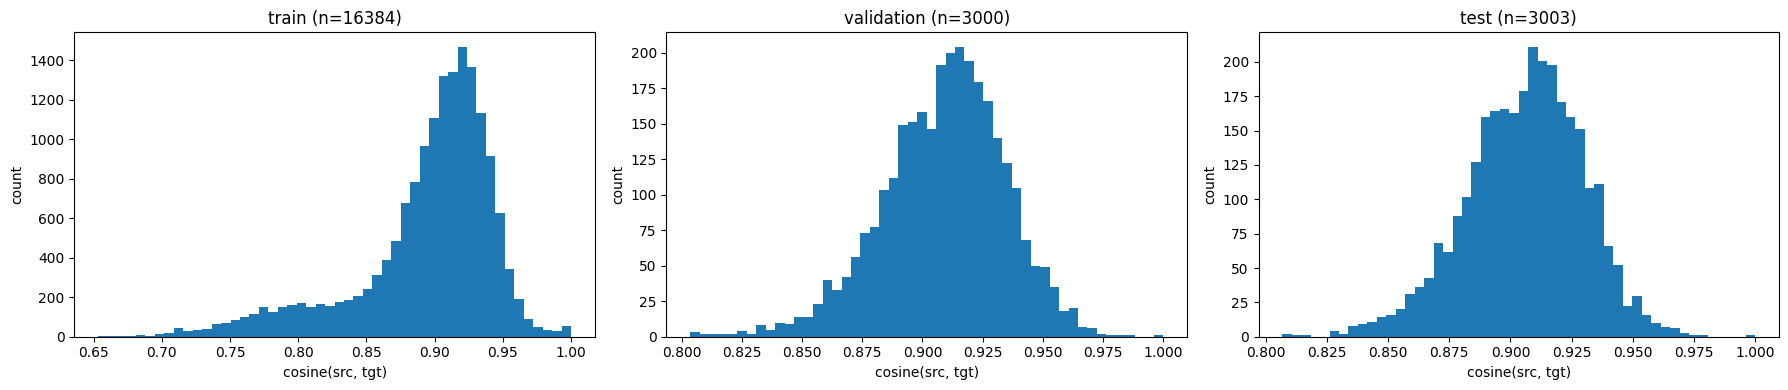

In [ ]:
SAVE_PATH = "/content/cosine_sims_wmt14_de_en_len204.npz"

try:
    cos_sim_data
    have_ram = True
except NameError:
    have_ram = False

if not have_ram:
    assert os.path.exists(SAVE_PATH), f"File non trovato: {SAVE_PATH}"
    data = np.load(SAVE_PATH, allow_pickle=False)
    cos_sim_data = {}
    if "train_sims" in data and data["train_sims"].size:
        cos_sim_data["train"] = {"idx": data["train_idx"], "sims": data["train_sims"]}
    if "val_sims" in data and data["val_sims"].size:
        cos_sim_data["validation"] = {"idx": data["val_idx"], "sims": data["val_sims"]}
    if "test_sims" in data and data["test_sims"].size:
        cos_sim_data["test"] = {"idx": data["test_idx"], "sims": data["test_sims"]}

splits = [s for s in ["train","validation","test"] if s in cos_sim_data]
plt.figure(figsize=(6*len(splits), 4))
for j, sp in enumerate(splits, start=1):
    sims = np.asarray(cos_sim_data[sp]["sims"])
    plt.subplot(1, len(splits), j)
    plt.hist(sims, bins=50)
    plt.title(f"{sp} (n={len(sims)})")
    plt.xlabel("cosine(src, tgt)")
    plt.ylabel("count")
    p10 = float(np.percentile(sims, 10)) if sims.size else 0.0
    thr_suggest = max(0.45, p10)
plt.tight_layout(); plt.show()


# Dataset exploration: distributions of likelihoods to be German and English

Use of the model facebook/fasttext-language-identification to measure the likelihood of src being German and tgt being English

model.bin:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

[train] n=16384  P(src=de) pct={'p10': 0.994, 'p50': 1.0, 'p90': 1.0}  P(tgt=en) pct={'p10': 0.996, 'p50': 1.0, 'p90': 1.0}
  soglia  keep_rate
   0.500     0.952
   0.526     0.951
   0.552     0.951
   0.577     0.951
   0.603     0.950
   0.629     0.950
   0.655     0.949
   0.681     0.949
   0.706     0.948
   0.732     0.948
   0.758     0.947
   0.784     0.946
   0.809     0.945
   0.835     0.943
   0.861     0.942
   0.887     0.940
   0.913     0.938
   0.938     0.933
   0.964     0.924
   0.990     0.885
[validation] n=3000  P(src=de) pct={'p10': 0.997, 'p50': 1.0, 'p90': 1.0}  P(tgt=en) pct={'p10': 0.998, 'p50': 1.0, 'p90': 1.0}
  soglia  keep_rate
   0.500     0.990
   0.526     0.990
   0.552     0.990
   0.577     0.990
   0.603     0.989
   0.629     0.989
   0.655     0.988
   0.681     0.988
   0.706     0.988
   0.732     0.986
   0.758     0.985
   0.784     0.983
   0.809     0.983
   0.835     0.982
   0.861     0.979
   0.887     0.978
   0.913     0.975
   0.

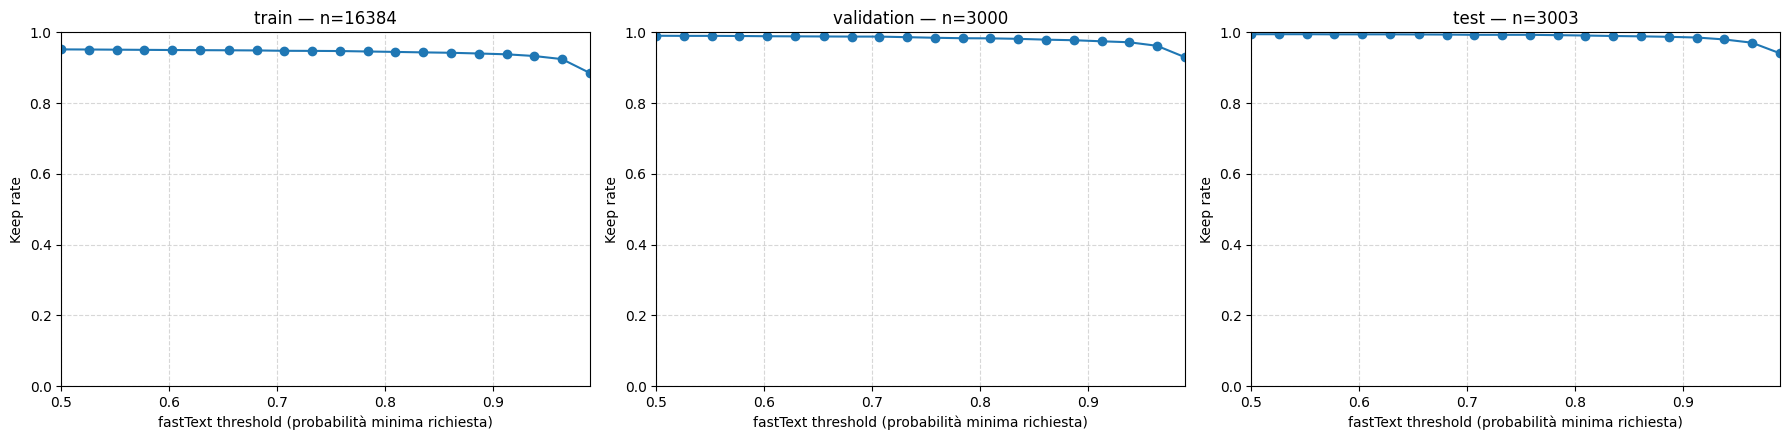

In [ ]:
import fasttext
# Keep rate vs fastText threshold — train/val/test ===
# train: sample of 8192 translations
# record is "kept" if P(src=deu_Latn) >= thr AND P(tgt=eng_Latn) >= thr
from huggingface_hub import hf_hub_download
import re

# --------------------
# Config
# --------------------
SPLITS          = ["train", "validation", "test"]
TRAIN_SAMPLE_N  = 16384
SEED            = 3407
THRESHOLDS      = np.round(np.linspace(0.50, 0.99, 20), 3)   # thresholds
LAB_DE          = "__label__deu_Latn"                        # labels lid218e
LAB_EN          = "__label__eng_Latn"
TOP_K           = 10                                         # search labels in topk

# --------------------
# Load model
# --------------------
lid_path = hf_hub_download(repo_id="facebook/fasttext-language-identification", filename="model.bin")
lid = fasttext.load_model(lid_path)

def clean_text(x: str, max_chars=2000) -> str:
    x = (x or "").replace("\r", " ").replace("\n", " ").strip()
    return re.sub(r"\s+", " ", x)[:max_chars]

def ft_prob_lang(text: str, label: str, k: int = TOP_K) -> float:
    """Probabilità specifica per una label (0.0 se non appare nelle top-k)."""
    labels, probs = lid.predict(clean_text(text), k=k)
    for l, p in zip(labels, probs):
        if l == label:
            return float(p)
    return 0.0

def pct(a, ps=(10,50,90)):
    a = np.asarray(a);
    return {f"p{p}": round(np.percentile(a, p),3) for p in ps} if len(a) else {}

# --------------------
# Calcolo per ogni split
# --------------------
results = {}  # {split: {"thr": THRESHOLDS, "keep": keep_rates, "n": N, "src_p":..., "tgt_p":...}}

rng = np.random.default_rng(SEED)
for sp in SPLITS:
    dset = ds[sp]
    N = len(dset)
    if sp == "train":
        idx = rng.choice(N, size=min(TRAIN_SAMPLE_N, N), replace=False)
    else:
        idx = np.arange(N)  # use all for val/test

    trans = dset.select(idx.tolist())["translation"]
    src_texts = [ex.get(SRC, "") for ex in trans]
    tgt_texts = [ex.get(TGT, "") for ex in trans]

    # Probabilities
    src_p = np.array([ft_prob_lang(s, LAB_DE) for s in src_texts], dtype=np.float32)
    tgt_p = np.array([ft_prob_lang(t, LAB_EN) for t in tgt_texts], dtype=np.float32)

    # Keep per thresholds
    keep_rates = []
    for thr in THRESHOLDS:
        keep = (src_p >= thr) & (tgt_p >= thr)
        keep_rates.append(keep.mean())
    keep_rates = np.array(keep_rates, dtype=np.float32)

    results[sp] = {"thr": THRESHOLDS, "keep": keep_rates, "n": len(src_p), "src_p": src_p, "tgt_p": tgt_p}

    # Log
    print(f"[{sp}] n={len(src_p)}  P(src=de) pct={pct(src_p)}  P(tgt=en) pct={pct(tgt_p)}")
    print("  threshold  keep_rate")
    for t, kr in zip(THRESHOLDS, keep_rates):
        print(f"  {t:6.3f}   {kr:7.3f}")

# --------------------
# Plot
# --------------------
splits_presenti = [s for s in SPLITS if s in results]
cols = len(splits_presenti)
plt.figure(figsize=(6*cols, 4.5))
for j, sp in enumerate(splits_presenti, start=1):
    data = results[sp]
    plt.subplot(1, cols, j)
    plt.plot(data["thr"], data["keep"], marker="o")
    plt.ylim(0.0, 1.0)
    plt.xlim(float(THRESHOLDS.min()), float(THRESHOLDS.max()))
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.xlabel("fastText threshold (minimum probability required)")
    plt.ylabel("Keep rate")
    plt.title(f"{sp} — n={data['n']}")
plt.tight_layout()
plt.show()


# Dataset exploration: length ratios between src and tgt

Analysing length ratios between src and tgt

In [ ]:
# === Keep rate per length ratio su train-sampled / val full / test full ===
import numpy as np

def keep_rate_ratio(len_src, len_tgt, rmin, rmax):
    len_src = np.asarray(len_src); len_tgt = np.asarray(len_tgt)
    if len_src.size == 0 or len_tgt.size == 0: return 0.0
    ratio = len_src / np.maximum(1, len_tgt)
    mask = (ratio >= rmin) & (ratio <= rmax)
    return float(mask.mean())

def report(split_name, len_src, len_tgt, note=""):
    pairs = [("0.50–2.00", 0.50, 2.00),
             ("0.33–3.00", 0.33, 3.00),
             ("0.25–4.00", 0.25, 4.00)]
    print(f"[{split_name}] {note} n={len(len_src)}")
    for label, rmin, rmax in pairs:
        kr = keep_rate_ratio(len_src, len_tgt, rmin, rmax)
        print(f"  ratio {label}: keep_rate = {kr:.3f}")

# train: sampled; val/test: full se disponibili
report("train",      trainS_len_src, trainS_len_tgt, note="sampled")
if 'val_len_src'  in globals() and val_len_src  is not None:  report("validation", val_len_src,  val_len_tgt,  note="full")
if 'test_len_src' in globals() and test_len_src is not None: report("test",       test_len_src, test_len_tgt, note="full")


[train] sampled n=65536
  ratio 0.50–2.00: keep_rate = 0.894
  ratio 0.33–3.00: keep_rate = 0.976
  ratio 0.25–4.00: keep_rate = 0.990
[validation] full n=3000
  ratio 0.50–2.00: keep_rate = 0.945
  ratio 0.33–3.00: keep_rate = 0.999
  ratio 0.25–4.00: keep_rate = 0.999
[test] full n=3003
  ratio 0.50–2.00: keep_rate = 0.958
  ratio 0.33–3.00: keep_rate = 0.999
  ratio 0.25–4.00: keep_rate = 1.000


# Sampling from training set

For the computational resources available it would be too much to use the entire dataset

In [ ]:
# === New dataset: train sampled 100k, val/test identici ===
from datasets import DatasetDict
import numpy as np

SEED = 3407
TRAIN_N = 100_000

N = len(ds["train"])
idx_100k = np.random.default_rng(SEED).choice(N, size=min(TRAIN_N, N), replace=False)
train_100k = ds["train"].select(idx_100k.tolist())

val_same  = ds.get("validation")
test_same = ds.get("test")

raw_100k = DatasetDict({k:v for k,v in {
    "train": train_100k,
    "validation": val_same,
    "test": test_same,
}.items() if v is not None})

print({k: len(v) for k,v in raw_100k.items()})


{'train': 100000, 'validation': 3000, 'test': 3003}


# Preprocessing
Filters:
*   src_len + tgt_len <= 203    (99 percentile)
*   0.5 < len_ratio < 2
*   cosine similarity > 0.88 (25 percentile)
*   src LID > 0.99 && tgt LID >0.99



In [ ]:
# === Preprocessing train(100k): ratio, len<=203, cosine>=0.88, LID>=0.99; val/test invariati ===
import numpy as np, unicodedata, re, torch
from transformers import AutoTokenizer, AutoModel

# ---- Thresholds (modificabili) ----
LEN_RATIO_MIN  = 0.5
LEN_RATIO_MAX  = 2.0
SUM_MAX_TOK    = 203
SIM_THRESHOLD  = 0.88
LID_THRESHOLD  = 0.99

# ---- Normalizzazione ----
def nfkc(s: str) -> str:
    return unicodedata.normalize("NFKC", s or "")

# ---- 1) Aggiungi lunghezze token al train_100k (usa il tokenizer Qwen già caricato) ----
def add_lengths(batch):
    src = [x[SRC] for x in batch["translation"]]
    tgt = [x[TGT] for x in batch["translation"]]
    e1 = tokenizer(src, add_special_tokens=False, return_length=True,
                   return_attention_mask=False, return_token_type_ids=False)
    e2 = tokenizer(tgt, add_special_tokens=False, return_length=True,
                   return_attention_mask=False, return_token_type_ids=False)
    len_src = e1["length"]; len_tgt = e2["length"]
    return {
        "len_src": len_src,
        "len_tgt": len_tgt,
        "len_sum": (np.array(len_src) + np.array(len_tgt)).tolist(),
    }

train_100k_with_len = raw_100k["train"].map(
    add_lengths, batched=True, batch_size=4096, num_proc=2,
    desc="[train100k] add token lengths",
)

# ---- 2) Filtro preliminare per ratio e somma lunghezze ----
def keep_len_ratio(ex):
    if ex["len_src"] < 1 or ex["len_tgt"] < 1: return False
    r = ex["len_src"] / max(1, ex["len_tgt"])
    return (LEN_RATIO_MIN <= r <= LEN_RATIO_MAX) and (ex["len_sum"] <= SUM_MAX_TOK)

train_len_ok = train_100k_with_len.filter(keep_len_ratio, desc=f"[train100k] filter ratio[{LEN_RATIO_MIN},{LEN_RATIO_MAX}] & len_sum<={SUM_MAX_TOK}")
print("Dopo filtro ratio+len:", len(train_len_ok))

# ---- 3) Aggiungi colonne testuali normalizzate (src_txt/tgt_txt) ----
def to_cols(batch):
    src = [nfkc(x[SRC]) for x in batch["translation"]]
    tgt = [nfkc(x[TGT]) for x in batch["translation"]]
    return {"src_txt": src, "tgt_txt": tgt}

train_txt = train_len_ok.map(
    to_cols, batched=True, batch_size=4096,
    desc="[train100k] add src_txt/tgt_txt",
)

# ---- 4) LID con fastText: prob(label specifica) ----
import fasttext
from huggingface_hub import hf_hub_download

LAB_DE = "__label__deu_Latn"
LAB_EN = "__label__eng_Latn"
ALL_LANGS_K = 218

lid_path = hf_hub_download(repo_id="facebook/fasttext-language-identification", filename="model.bin")
lid = fasttext.load_model(lid_path)

def clean_text(x: str, max_chars=2000) -> str:
    x = (x or "").replace("\r"," ").replace("\n"," ").strip()
    return re.sub(r"\s+"," ", x)[:max_chars]

def prob_label(text: str, wanted: str) -> float:
    labels, probs = lid.predict(clean_text(text), k=ALL_LANGS_K)
    for i, l in enumerate(labels):
        if l == wanted: return float(probs[i])
    return 0.0

def add_lid(batch):
    src_p = [prob_label(x, LAB_DE) for x in batch["src_txt"]]
    tgt_p = [prob_label(x, LAB_EN) for x in batch["tgt_txt"]]
    return {"p_src_de": src_p, "p_tgt_en": tgt_p}

train_lid = train_txt.map(
    add_lid, batched=True, batch_size=1024,
    desc="[train100k] LID fastText (prob de/en)",
)

def keep_lid(ex):
    return (ex["p_src_de"] >= LID_THRESHOLD) and (ex["p_tgt_en"] >= LID_THRESHOLD)

train_lid_ok = train_lid.filter(keep_lid, desc=f"[train100k] filter LID≥{LID_THRESHOLD}")
print("Dopo filtro LID:", len(train_lid_ok))

# ---- 5) Cosine similarity con E5 (multilingual-e5-small) ----
EMB_MODEL = "intfloat/multilingual-e5-small"
device = "cuda" if torch.cuda.is_available() else "cpu"
e5_tok = AutoTokenizer.from_pretrained(EMB_MODEL)
e5_mod = AutoModel.from_pretrained(EMB_MODEL, torch_dtype=(torch.float16 if device=="cuda" else None)).eval().to(device)

@torch.inference_mode()
def embed_texts(texts, batch_size=1024, max_len=256):
    outs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = e5_tok(batch, padding=True, truncation=True, max_length=max_len, return_tensors="pt").to(device)
        last = e5_mod(**enc).last_hidden_state
        mask = enc["attention_mask"].unsqueeze(-1).float()
        pooled = (last * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-9)
        pooled = torch.nn.functional.normalize(pooled, p=2, dim=1)
        outs.append(pooled.cpu())
    return torch.cat(outs, dim=0).numpy()

def cosine_batch(a, b):
    return (a * b).sum(axis=1)

def add_cosine(batch):
    E_src = embed_texts(batch["src_txt"])
    E_tgt = embed_texts(batch["tgt_txt"])
    sims  = cosine_batch(E_src, E_tgt).tolist()
    return {"cos_sim": sims}

train_cos = train_lid_ok.map(
    add_cosine, batched=True, batch_size=1024,
    desc="[train100k] cosine(E5)",
)

train_final = train_cos.filter(lambda ex: ex["cos_sim"] >= SIM_THRESHOLD, desc=f"[train100k] filter cos_sim≥{SIM_THRESHOLD}")
print("Dopo filtro cosine:", len(train_final))

# ---- 6) Proiezione finale: tieni solo colonne pulite per SFT ----
cols_to_keep = ["src_txt", "tgt_txt"]
for c in ["src_txt","tgt_txt"]:
    assert c in train_final.column_names, f"Colonna mancante: {c}"

train_proc_100k = train_final.remove_columns([c for c in train_final.column_names if c not in cols_to_keep])

# val/test invariati
val_proc_same  = raw_100k.get("validation")
test_proc_same = raw_100k.get("test")

print({
    "train_proc_100k": len(train_proc_100k),
    "validation_same": (len(val_proc_same)  if val_proc_same  is not None else 0),
    "test_same":       (len(test_proc_same) if test_proc_same is not None else 0),
})


[train100k] add token lengths (num_proc=2):   0%|          | 0/100000 [00:00<?, ? examples/s]

[train100k] filter ratio[0.5,2.0] & len_sum<=203:   0%|          | 0/100000 [00:00<?, ? examples/s]

Dopo filtro ratio+len: 88218


[train100k] add src_txt/tgt_txt:   0%|          | 0/88218 [00:00<?, ? examples/s]

[train100k] LID fastText (prob de/en):   0%|          | 0/88218 [00:00<?, ? examples/s]

[train100k] filter LID≥0.99:   0%|          | 0/88218 [00:00<?, ? examples/s]

Dopo filtro LID: 78965


[train100k] cosine(E5):   0%|          | 0/78965 [00:00<?, ? examples/s]

[train100k] filter cos_sim≥0.88:   0%|          | 0/78965 [00:00<?, ? examples/s]

Dopo filtro cosine: 62240
{'train_proc_100k': 62240, 'validation_same': 3000, 'test_same': 3003}


# Saving on drive

In [ ]:
# === Salva su Google Drive: train_proc_100k + val/test invariati ===
from datasets import DatasetDict
from google.colab import drive
import os

drive.mount("/content/drive")

SAVE_DIR = "/content/drive/MyDrive/mt_datasets/wmt14_de_en_proc_100k_len203_sim082_lid099"
os.makedirs(os.path.dirname(SAVE_DIR), exist_ok=True)

ds_out = DatasetDict({k:v for k,v in {
    "train":      train_proc_100k,
    "validation": raw_100k.get("validation"),
    "test":       raw_100k.get("test"),
}.items() if v is not None})

print({k: len(v) for k,v in ds_out.items()})
ds_out.save_to_disk(SAVE_DIR)
print("✔️ Salvato in:", SAVE_DIR)


Mounted at /content/drive
{'train': 62240, 'validation': 3000, 'test': 3003}


Saving the dataset (0/1 shards):   0%|          | 0/62240 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3003 [00:00<?, ? examples/s]

✔️ Salvato in: /content/drive/MyDrive/mt_datasets/wmt14_de_en_proc_100k_len203_sim082_lid099


In [ ]:
# Pulisce metadata dei widget e lascia gli output "statici" intatti
import nbformat as nbf

IN  = "/content/drive/MyDrive/Colab Notebooks/mio_notebook.ipynb"  # <-- cambia path
OUT = IN  # sovrascrive in place

WIDGET_MIMES = {
    "application/vnd.jupyter.widget-view+json",
    "application/vnd.jupyter.widget-state+json",
}

nb = nbf.read(IN, as_version=nbf.NO_CONVERT)

# 1) rimuovi metadata.widgets a livello notebook
if "widgets" in nb.metadata:
    del nb.metadata["widgets"]

for cell in nb.cells:
    # 2) rimuovi metadata.widgets a livello cella (se presente)
    if hasattr(cell, "metadata") and "widgets" in cell.metadata:
        del cell.metadata["widgets"]
    # 3) dagli output, elimina solo i MIME dei widget (mantieni testo/immagini/HTML)
    if hasattr(cell, "outputs"):
        for out in cell.outputs:
            if getattr(out, "data", None):
                for m in list(out.data.keys()):
                    if m in WIDGET_MIMES:
                        del out.data[m]

nbf.write(nb, OUT)
print("Notebook pulito e salvato:", OUT)
